# Pipeline for High-z Radio Galaxies 10: Radio detection classification

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

***

## Reading data

In [13]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [14]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [15]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [16]:
mqc_version = '7_4d'  # '7_2'

In [17]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [18]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [19]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [20]:
# full_catalog_df.describe()

#### Load previous model to create labels for unknown sources.

In [21]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

In [22]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index
final_indices     = confirmed_indices.union(unknown_indices)  # all

In [23]:
# if load_model_flag:
AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')

Transformation Pipeline and Model Successfully Loaded


In [24]:
AGN_pred_threshold = 0.5
new_labels_train   = pyc.predict_model(AGN_gal_clf,\
                    data=full_catalog_df.loc[unknown_indices],\
                    probability_threshold=AGN_pred_threshold, raw_score=True).loc[:, 'Score_1']

In [25]:
full_catalog_df.loc[unknown_indices, 'class'] = new_labels_train

#### Select only confirmed and highly likely AGN

In [26]:
AGN_threshold = 0.95
gal_threshold = 0.05

In [27]:
filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)
filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] < gal_threshold) & (full_catalog_df.loc[:, 'class'] > 0.00)
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)

In [28]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 0) | (full_catalog_df.loc[:, 'class'] == 1)]

In [29]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

In [30]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'class'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'class'] == 0)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 832364 elements,
78934 of them are marked as AGN, and 753430 are identified as galaxies.


---

## Possible correlations

In [31]:
print(full_catalog_df.columns.to_list())

['band_num', 'radio_detect', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2', 'class']


---

## Random seed

In [32]:
seed = 42

Create target

In [33]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Remove intermediate targets

In [34]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'class'])

## Split data: Test, Train, Validation

In [35]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
     random_state=seed, stratify=full_catalog_df.loc[:, 'radio_detect'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (832364, 39)
Data for Modeling (Train and Test): (665891, 39)
Unseen Data For Validation: (166473, 39)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [36]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [37]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [38]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [39]:
rsd_vals

radio_detect    271.939550
z_y             210.571419
i_z             138.523531
r_i              86.924853
g_r              81.490023
g_i              48.752462
J_H              37.183446
H_K              26.818626
band_num         25.399335
w2_w3            20.895014
w3_w4             9.019115
rmag              7.729199
gmag              7.401169
r/H               7.231034
g/J               6.817896
imag              6.707056
i/K               6.598787
zmag              6.378987
ymag              6.352097
z/W1              5.747947
y/W2              5.617493
W1mproPM          4.345570
w1/w4             4.277217
w1/w3             4.121395
r/z               3.503944
W2mproPM          3.246984
w2/w4             3.149305
i/y               2.824932
Hmag              1.499143
Jmag              1.440569
W3mag             1.336677
J/K               1.165028
NUVmag            1.062891
FUV/K             0.735230
Kmag              0.629263
W4mag             0.559244
FUVmag            0.383992
F

In [40]:
correlation = norm_train_test_df.corr()

In [41]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [42]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [43]:
target_feat = 'radio_detect'

In [44]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [45]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [46]:
list_drop_corr

['i/K',
 'w1/w4',
 'r/H',
 'g/J',
 'w2/w4',
 'w1/w3',
 'FUV_NUV',
 'W3mag',
 'Jmag',
 'W2mproPM',
 'zmag',
 'Hmag',
 'imag',
 'J/K',
 'gmag',
 'ymag',
 'W1mproPM',
 'Kmag',
 'y/W2',
 'r/z',
 'rmag']

In [47]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [48]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [49]:
corr_discard = norm_train_test_discard.corr()

In [50]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num      band_num    1.000000
NUVmag        FUVmag      0.663952
i/y           z_y         0.638171
g_i           g_r         0.616509
              r_i         0.541666
i/y           i_z         0.509502
H_K           w2_w3       0.481254
w2_w3         band_num    0.471296
FUV/K         FUVmag      0.456201
w3_w4         NUVmag      0.438550
band_num      H_K         0.436549
z/W1          band_num    0.414575
radio_detect  w3_w4       0.385322
w3_w4         W4mag       0.365574
z_y           i_z         0.334005
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

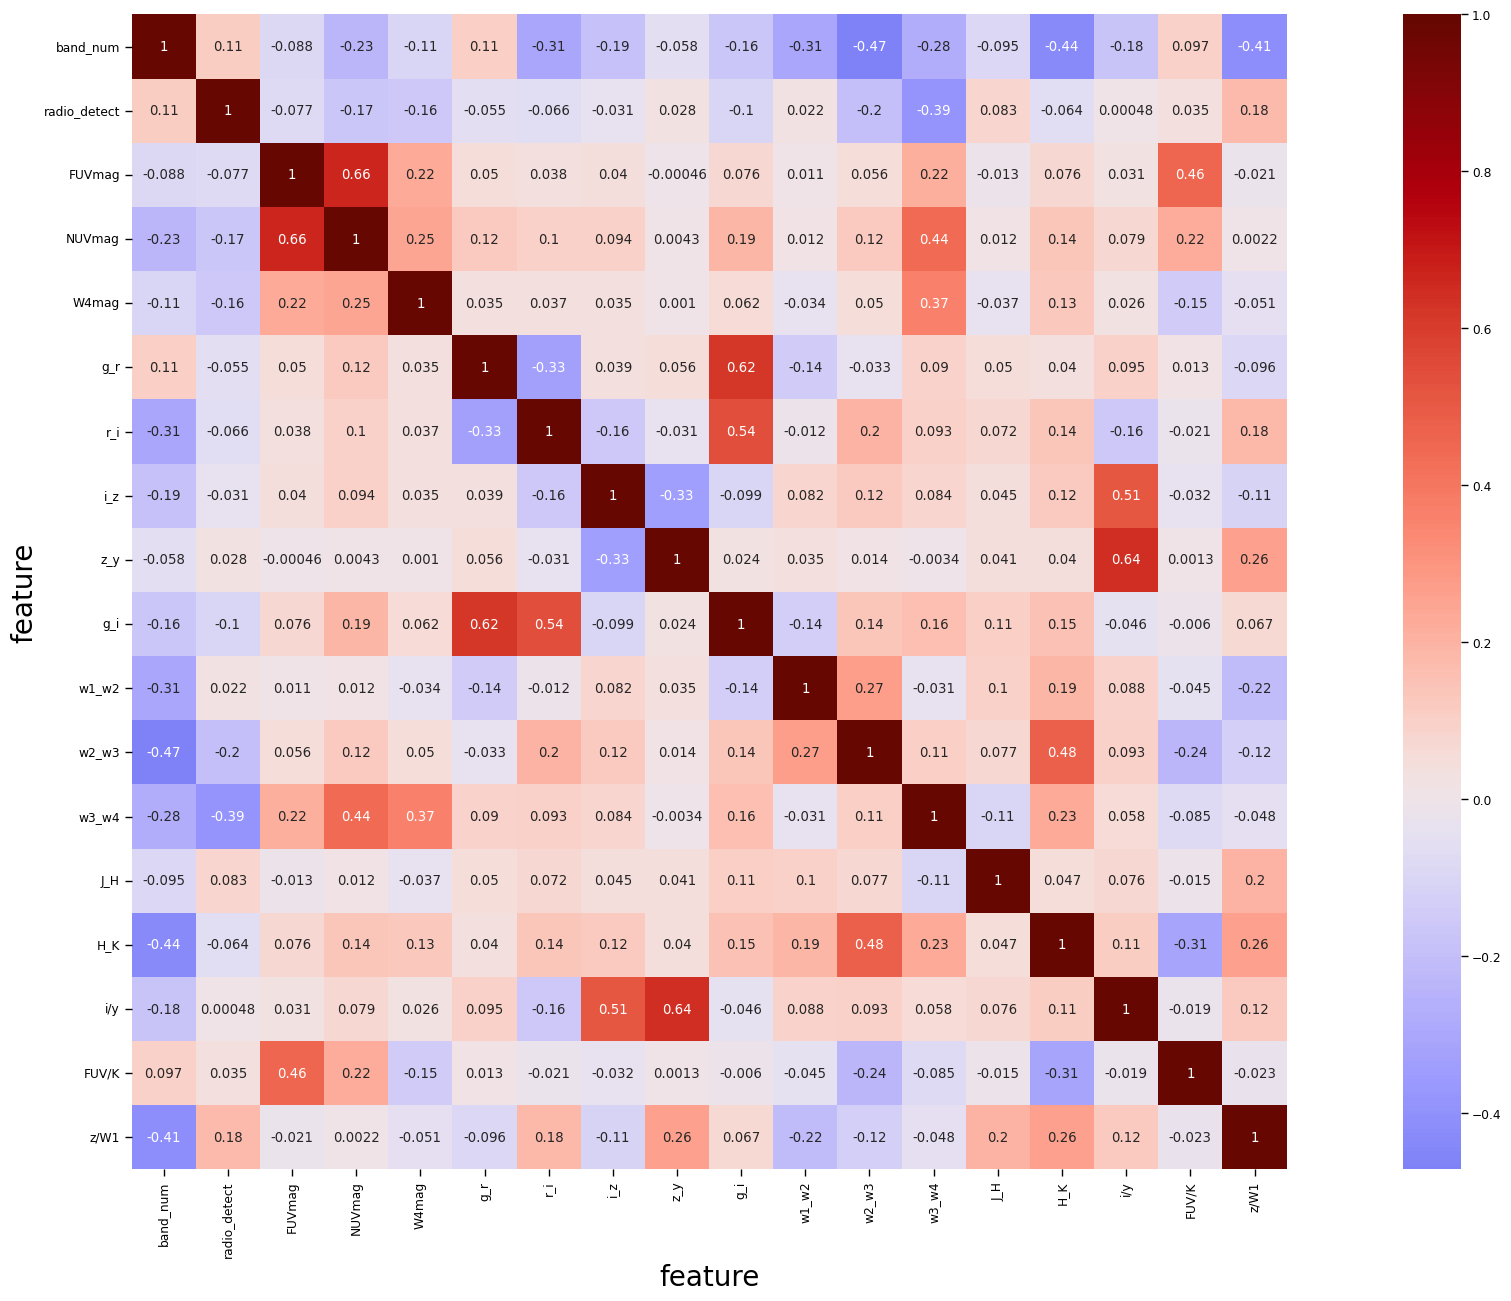

In [51]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [52]:
norm_train_test_discard.loc[:, 'radio_detect'] = norm_train_test_discard.loc[:, 'radio_detect'].astype(bool)

In [53]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [54]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y           
FUV/K     FUV/K           1.000000
          FUVmag          0.529413
g_r       g_i             0.373104
NUVmag    FUVmag          0.327014
band_num  g_r             0.272750
          r_i             0.258884
z_y       i/y             0.246749
r_i       g_i             0.246712
w3_w4     radio_detect    0.231796
band_num  g_i             0.214877
r_i       g_r             0.200868
band_num  i/y             0.184892
          z/W1            0.182501
i/y       z_y             0.177184
g_i       g_r             0.175278
g_r       r_i             0.159799
J_H       band_num        0.155320
band_num  z_y             0.153502
J_H       H_K             0.149466
H_K       band_num        0.135011
dtype: float64

In [55]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [56]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [57]:
target_feat = 'radio_detect'

In [58]:
list_drop_pps = []

In [59]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [60]:
list_drop_pps

[]

In [61]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [62]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'radio_detect', random_seed=seed)

In [63]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w3_w4,radio_detect,0.231796,classification,True,weighted F1,0.820963,0.862463,DecisionTreeClassifier()
1,band_num,radio_detect,0.132468,classification,True,weighted F1,0.820963,0.844679,DecisionTreeClassifier()
2,W4mag,radio_detect,0.077524,classification,True,weighted F1,0.820963,0.834842,DecisionTreeClassifier()
3,NUVmag,radio_detect,0.067240,classification,True,weighted F1,0.820963,0.833001,DecisionTreeClassifier()
4,FUV/K,radio_detect,0.052818,classification,True,weighted F1,0.820963,0.830419,DecisionTreeClassifier()
5,FUVmag,radio_detect,0.024708,classification,True,weighted F1,0.820963,0.825386,DecisionTreeClassifier()
6,J_H,radio_detect,0.021761,classification,True,weighted F1,0.820963,0.824859,DecisionTreeClassifier()
7,H_K,radio_detect,0.016645,classification,True,weighted F1,0.820963,0.823943,DecisionTreeClassifier()
8,g_r,radio_detect,0.000000,classification,True,weighted F1,0.820963,0.794940,DecisionTreeClassifier()
9,r_i,radio_detect,0.000000,classification,True,weighted F1,0.820963,0.794631,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [64]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta
# final_feats.remove('FUVmag')

In [65]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [66]:
exp_radio = pyc.setup(data=train_test_df, target='radio_detect', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,radio_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(665891, 39)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [67]:
pyc.get_config('X').columns

Index(['band_num', 'FUVmag', 'NUVmag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y',
       'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'i/y', 'FUV/K', 'z/W1'],
      dtype='object')

In [68]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [69]:
# used_models_clf      = ['catboost','xgboost', 'lightgbm', 'rf', 'et', 'lr', 'dt', 'svm', 'lda']  # knn too slow, ridge does not work
final_selection_clf  = ['catboost', 'rf', 'et', 'xgboost', 'lightgbm', 'dummy']
n_models             = 5
top_model_radio = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort='MCC')  # 1:15 hour for used_models_clf
# top_model_radio = pyc.compare_models(n_select=n_models, exclude=['knn'], sort='MCC')  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9024,0.8592,0.2826,0.7348,0.4082,0.3662,0.4164,12.4800
rf,Random Forest Classifier,0.9015,0.8463,0.2964,0.7059,0.4174,0.3733,0.4156,12.6870
et,Extra Trees Classifier,0.9009,0.8385,0.2969,0.6980,0.4165,0.3719,0.4128,7.1990
xgboost,Extreme Gradient Boosting,0.9021,0.8568,0.2736,0.7423,0.3997,0.3586,0.4122,13.0830
lightgbm,Light Gradient Boosting Machine,0.9023,0.8570,0.2586,0.7672,0.3868,0.3476,0.4092,28.7010
dummy,Dummy Classifier,0.8809,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0470


Thus, we select `Catboost` as meta learner.

Thus, we stack the models.

In [70]:
stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[1:], meta_model=top_model_radio[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9030,0.8617,0.2780,0.7510,0.4058,0.3650,0.4190
1,0.9032,0.8642,0.2916,0.7376,0.4179,0.3758,0.4244
2,0.9026,0.8615,0.2820,0.7387,0.4082,0.3665,0.4175
3,0.9044,0.8654,0.2995,0.7454,0.4273,0.3854,0.4335
4,0.9038,0.8612,0.2929,0.7438,0.4203,0.3784,0.4278
5,0.9032,0.8641,0.2954,0.7318,0.4209,0.3783,0.4251
6,0.9032,0.8598,0.2939,0.7335,0.4197,0.3773,0.4247
7,0.9017,0.8581,0.2857,0.7206,0.4091,0.3663,0.4134
8,0.9022,0.8606,0.2849,0.7287,0.4097,0.3673,0.4159


In [71]:
tuned_radio_clf = pyc.tune_model(stacked_model_radio, early_stopping='asha', optimize='MCC',\
                                 search_library='tune-sklearn', search_algorithm='random')  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9040,0.8609,0.2687,0.7824,0.4000,0.3611,0.4229
1,0.9041,0.8633,0.2815,0.7647,0.4115,0.3712,0.4268
2,0.9039,0.8595,0.2721,0.7753,0.4028,0.3634,0.4231
3,0.9047,0.8653,0.2902,0.7628,0.4204,0.3797,0.4329
4,0.9045,0.8603,0.2869,0.7644,0.4172,0.3767,0.4310
5,0.9043,0.8647,0.2803,0.7703,0.4110,0.3710,0.4279
6,0.9035,0.8591,0.2785,0.7586,0.4074,0.3669,0.4221
7,0.9026,0.8567,0.2763,0.7461,0.4033,0.3622,0.4158
8,0.9026,0.8603,0.2758,0.7468,0.4028,0.3618,0.4156


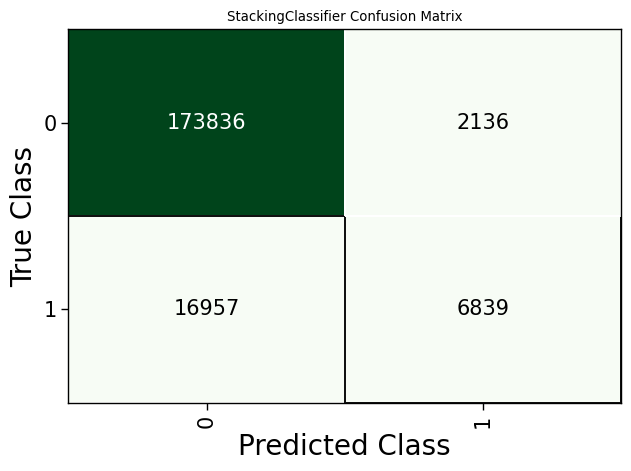

In [72]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

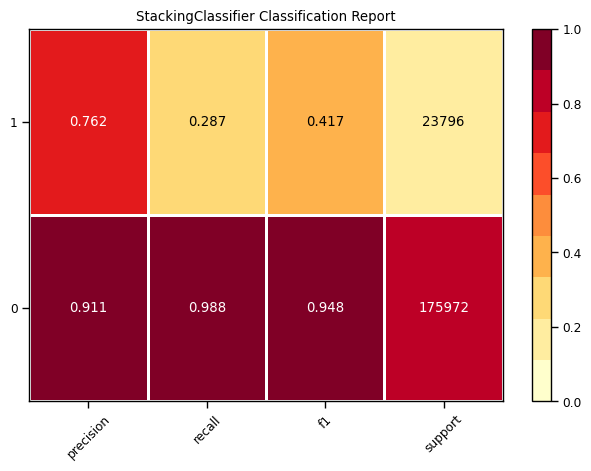

In [73]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

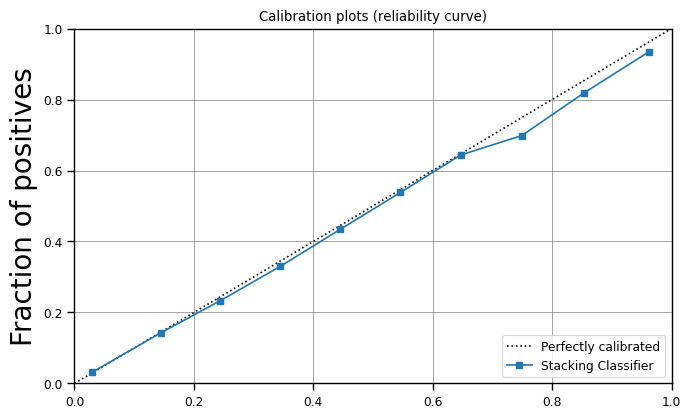

In [74]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

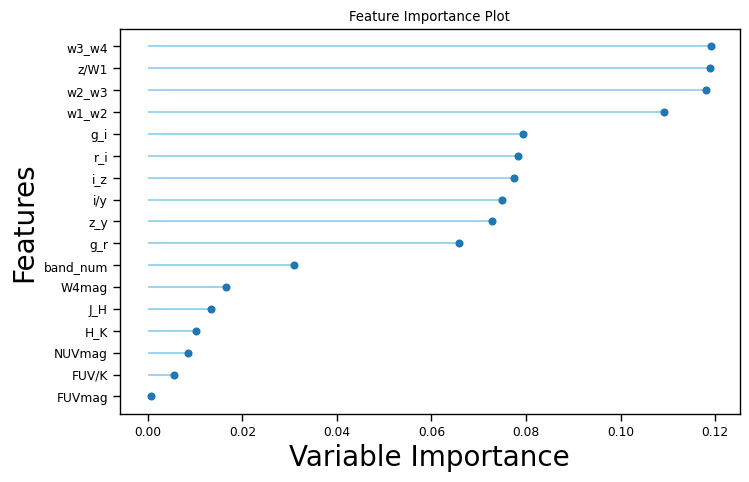

In [75]:
pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [76]:
pyc.plot_model(tuned_radio_clf, plot='parameter')

,Parameters
cv,5
estimators,"[('rf', RandomForestClassifier(bootstrap=True,..."
final_estimator,<catboost.core.CatBoostClassifier object at 0x...
n_jobs,12
passthrough,True
stack_method,auto
verbose,0


In [77]:
plt.rcParams.update(plt.rcParamsDefault)

In [78]:
pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9044,0.8646,0.2874,0.7620,0.4174,0.3767,0.4305


,band_num,FUVmag,NUVmag,W4mag,g_r,r_i,i_z,z_y,g_i,w1_w2,...,w3_w4,J_H,H_K,i/y,FUV/K,z/W1,radio_detect,Label,Score_0,Score_1
0,1.930736,0.078459,0.199834,0.092575,-0.636411,-0.911302,-0.665511,-0.362016,-1.258130,-1.081357,...,0.177007,-3.142017,-2.889299,-0.858622,-0.043331,-1.959527,0,0,0.9835,0.0165
1,0.307624,0.078459,0.199834,0.092575,0.423863,-0.423851,0.285516,0.000471,-0.083505,-0.464888,...,0.177007,0.045682,0.268599,0.285387,-0.043331,0.238685,0,0,0.9172,0.0828
2,-0.842332,0.078459,0.199834,0.092575,-1.081941,0.992448,1.264762,-1.552712,-0.246823,-0.069761,...,0.177007,0.045682,0.268599,-0.455017,-0.043331,0.996382,0,0,0.8011,0.1989
3,1.518214,0.078459,0.199834,0.092575,-0.448990,-0.799692,0.136628,-0.102816,-1.049653,-0.282568,...,0.177007,1.144404,-1.018739,0.140202,-0.043331,-1.047966,0,0,0.9490,0.0510
4,-0.466009,0.078459,0.199834,0.092575,1.195349,-0.209351,-0.596220,-1.416896,0.835964,-0.793275,...,0.177007,0.045682,0.268599,-1.818142,-0.043331,0.969570,0,0,0.8878,0.1122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199763,0.705812,0.078459,0.199834,0.092575,-1.042082,-1.169238,-0.484935,-0.148858,-1.699751,1.505747,...,-3.963355,0.045682,0.268599,-0.479882,-0.043331,-0.645010,0,1,0.3975,0.6025
199764,-0.466009,0.078459,0.199834,0.092575,-3.645983,1.524259,-2.512783,1.212810,-1.935811,-0.085951,...,0.177007,0.045682,0.268599,-1.159634,-0.043331,1.726571,0,0,0.8879,0.1121
199765,1.518214,0.078459,0.199834,0.092575,0.242707,-0.296649,-0.230351,-0.194360,-0.143865,-0.877140,...,0.177007,-1.471236,-2.838769,-0.216482,-0.043331,-1.366316,0,0,0.9830,0.0170
199766,1.109675,0.078459,-5.030167,0.092575,-0.673756,-0.341824,-1.095013,-0.037078,-0.936045,-0.336025,...,0.177007,0.045682,0.268599,-0.982125,-0.043331,0.035728,0,0,0.9575,0.0425


In [79]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9044,0.8646,0.2874,0.7620,0.4174,0.3767,0.4305


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [80]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

In [81]:
if save_model_flag:
    pyc.save_model(final_radio_clf, 'models/classification_radio_detect_may_09_2022')  # Model (it will be saved with .pkl extension)
    # pyc.save_config('models/config_classification_radio_detect_may_09_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    final_radio_clf = pyc.load_model('models/classification_radio_detect_may_09_2022')

### Prediction process

#### Feature importances

In [82]:
estimators_list = [estimator[0] for estimator in final_radio_clf.estimators]

In [83]:
extended_data_radio = validation_df.loc[:, get_final_column_names(final_radio_clf, validation_df)].copy()
extended_idx_radio  = extended_data_radio.index
initial_cols_radio  = extended_data_radio.columns
extended_cols_radio = extended_data_radio.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_radio = extended_cols_radio.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [84]:
print('Running data pre-processing:\n')
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_radio_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_radio = method.transform(extended_data_radio)
extended_data_radio_df = pd.DataFrame(extended_data_radio, columns=extended_cols_radio, index=extended_idx_radio)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [85]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    importances_coef = final_radio_clf.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_radio_clf.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_radio, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_radio))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [86]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_radio_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_radio_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_radio_clf.estimators
    estimators_list_ = final_radio_clf.estimators_

In [87]:
base_models_names = [model[0] for model in estimators_list]

In [88]:
coef_sorted_base_df = {}

In [89]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': np.abs(model_fit.coef_) *\
                                     extended_data_radio_df.loc[:, extended_cols_radio.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [90]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [91]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for rf...
Calculating for et...
Calculating for xgboost...
Calculating for lightgbm...


rf                   et              xgboost             lightgbm  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0       z/W1  12.059994     w2_w3  12.238050     w3_w4  51.206718      z/W1   
1      w3_w4  12.053410      z/W1  11.477529     w2_w3  12.930411     w1_w2   
2      w2_w3  11.773079     w3_w4  10.147102      z/W1   8.420409       r_i   
3      w1_w2  10.852642     w1_w2  10.132219     w1_w2   5.355179       i_z   
4        g_i   7.878536       g_i   7.889684  band_num   3.794363       g_i   
5        r_i   7.815770       r_i   7.749442       g_i   2.359368     w2_w3   
6        i_z   7.803639       i_z   7.721749     W4mag   2.241288       g_r   
7        i/y   7.517675       i/y   7.582560       r_i   1.780420  band_num   
8        z_y   7.311857       z_y   7.297045     FUV/K   1.708452       i/y   
9        g_r   6.585630       g_r   6.491581       i_z   1.693189     w3_w4   
10  band_num   3.086762     W4mag   3.644649       g_r   1.637827       z_y   
11     W4mag   1.573113  band_num   2.984645    NUVmag   1.584501     FUV/K   
12       J_H   1.275816    NUVmag   1.475603       H_K   1.326795       H_K   
13       H_K   1.016921       J_H   1.142981       i/y   1.195702       J_H   
14    NUVmag   0.769465       H_K   1.052079    FUVmag   0.996005     W4mag   
15     FUV/K   0.557693     FUV/K   0.617508       z_y   0.991866    NUVmag   
16    FUVmag   0.067999    FUVmag   0.355576       J_H   0.777514    FUVmag   

               
   Importance  
0   15.566667  
1   13.800000  
2    9.366667  
3    8.200000  
4    8.066667  
5    7.833333  
6    6.133333  
7    5.966667  
8    5.766667  
9    5.266667  
10   4.166667  
11   3.366667  
12   2.800000  
13   1.800000  
14   1.133333  
15   0.766667  
16   0.000000

In [92]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,et,25.959601
1,rf,22.691920
2,lightgbm,18.703614
3,z/W1,16.642161
4,xgboost,10.001267
5,band_num,3.068089
6,w1_w2,1.146487
7,w2_w3,0.976228
8,w3_w4,0.264597
9,H_K,0.211269


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
z/W1	15.562
w1_w2	13.795
r_i	9.363
i_z	8.198
g_i	8.065
w2_w3	7.838
g_r	6.132
band_num	5.964
i/y	5.766
w3_w4	5.286
z_y	4.168
FUV/K	3.364
H_K	2.798
J_H	1.799
W4mag	1.135
NUVmag	0.767
FUVmag	0.000


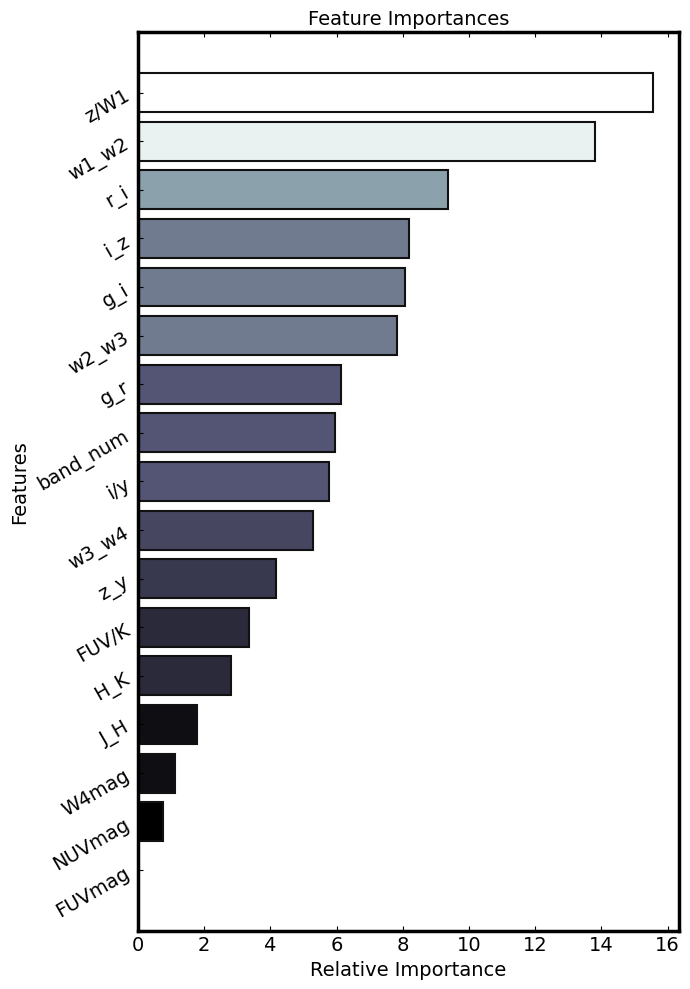

In [93]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_radio_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_radio_detect_03.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [94]:
radio_pred_threshold = 0.5
# radio_pred_threshold = 0.49999523  # from MCC optimisation - From S82 data

In [95]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9053,0.8664,0.2923,0.7701,0.4238,0.3834,0.4373


Create confusion matrix with validation data.

In [96]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

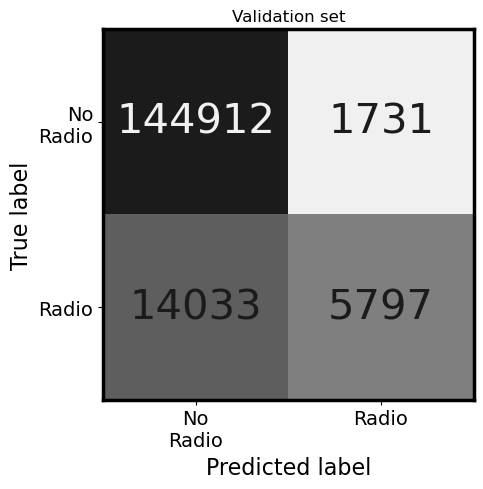

In [97]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_radio_detect_03.pdf', bbox_inches='tight')
plt.show()

In [98]:
# TN_radio, FP_radio, FN_radio, TP_radio = cm_mat_val.flatten().astype('float32')

In [99]:
MCC_radio_val    = MCC_from_CM(cm_mat_val)
ACC_radio_val    = ACC_from_CM(cm_mat_val)
F1_radio_val     = F1_from_CM(cm_mat_val)
Recall_radio_val = Recall_from_CM(cm_mat_val)

In [100]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_val:.4f}')
print(f'F1-score is                          F1 = {F1_radio_val:.4f}')
print(f'Recall is                           TPR = {Recall_radio_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.4373
Accuracy is                         ACC = 0.9053
F1-score is                          F1 = 0.4238
Recall is                           TPR = 0.2923


---

### Separate AGN and galaxies for Confusion Matrices

In [101]:
# validation_prediction_clf_AGN = validation_prediction_clf.loc[validation_prediction_clf.loc[:, 'class'] == 1]
# validation_prediction_clf_gal = validation_prediction_clf.loc[validation_prediction_clf.loc[:, 'class'] == 0]

In [102]:
# cm_mat_val_gal = np.array([[np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 0) & np.array(validation_prediction_clf_gal['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 0) & np.array(validation_prediction_clf_gal['Label'] == 1))],\
#         [np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 1) & np.array(validation_prediction_clf_gal['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 1) & np.array(validation_prediction_clf_gal['Label'] == 1))]])
# 
# cm_mat_val_AGN = np.array([[np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 0) & np.array(validation_prediction_clf_AGN['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 0) & np.array(validation_prediction_clf_AGN['Label'] == 1))],\
#         [np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 1) & np.array(validation_prediction_clf_AGN['Label'] == 0)),\
#           np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 1) & np.array(validation_prediction_clf_AGN['Label'] == 1))]])

In [103]:
# fig             = plt.figure(figsize=(6,5))
# ax1             = fig.add_subplot(111)
# 
# plot_conf_mat(cm_mat_val_gal, title='Galaxies', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
# plt.tight_layout()
# if save_plot_flag:
#     plt.savefig('plots/conf_matrix_validation_classification_radio_detect_gal_03.pdf', bbox_inches='tight')
# plt.show()

In [104]:
# fig             = plt.figure(figsize=(6,5))
# ax1             = fig.add_subplot(111)
#  
# plot_conf_mat(cm_mat_val_AGN, title='AGN', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
# plt.tight_layout()
# if save_plot_flag:
#     plt.savefig('plots/conf_matrix_validation_classification_radio_detect_AGN_03.pdf', bbox_inches='tight')
# plt.show()

In [105]:
# TN_radio_gal, FP_radio_gal, FN_radio_gal, TP_radio_gal = cm_mat_val_gal.flatten().astype('float32')
# TN_radio_AGN, FP_radio_AGN, FN_radio_AGN, TP_radio_AGN = cm_mat_val_AGN.flatten().astype('float32')

In [106]:
# MCC_radio_val_gal = ((TP_radio_gal * TN_radio_gal) - (FP_radio_gal * FN_radio_gal)) /\
#             np.sqrt((TP_radio_gal + FP_radio_gal) * (TP_radio_gal + FN_radio_gal) * (TN_radio_gal + FP_radio_gal) * (TN_radio_gal + FN_radio_gal))
# 
# ACC_radio_val_gal = (TP_radio_gal + TN_radio_gal) / (TP_radio_gal + TN_radio_gal + FP_radio_gal + FN_radio_gal)
# 
# F1_radio_val_gal  = 2 * TP_radio_gal / (2 * TP_radio_gal + FP_radio_gal + FN_radio_gal)
# 
# Recall_radio_val_gal = TP_radio_gal / (TP_radio_gal + FN_radio_gal)

In [107]:
# MCC_radio_val_AGN = ((TP_radio_AGN * TN_radio_AGN) - (FP_radio_AGN * FN_radio_AGN)) /\
#             np.sqrt((TP_radio_AGN + FP_radio_AGN) * (TP_radio_AGN + FN_radio_AGN) * (TN_radio_AGN + FP_radio_AGN) * (TN_radio_AGN + FN_radio_AGN))
# 
# ACC_radio_val_AGN = (TP_radio_AGN + TN_radio_AGN) / (TP_radio_AGN + TN_radio_AGN + FP_radio_AGN + FN_radio_AGN)
# 
# F1_radio_val_AGN  = 2 * TP_radio_AGN / (2 * TP_radio_AGN + FP_radio_AGN + FN_radio_AGN)
# 
# Recall_radio_val_AGN = TP_radio_AGN / (TP_radio_AGN + FN_radio_AGN)

In [108]:
# print('Metrics for galaxies in validation set:')
# print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val_gal:.4f}')
# print(f'Accuracy is                         ACC = {ACC_radio_val_gal:.4f}')
# print(f'F1-score is                          F1 = {F1_radio_val_gal:.4f}')
# print(f'Recall is                           TPR = {Recall_radio_val_gal:.4f}')

In [109]:
# print('Metrics for AGN in validation set:')
# print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val_AGN:.4f}')
# print(f'Accuracy is                         ACC = {ACC_radio_val_AGN:.4f}')
# print(f'F1-score is                          F1 = {F1_radio_val_AGN:.4f}')
# print(f'Recall is                           TPR = {Recall_radio_val_AGN:.4f}')

---

In [110]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['radio_detect']), train_test_df.loc[:, 'radio_detect'], False, 'radio_detect'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['radio_detect']),
                train_test_df.loc[:, 'radio_detect'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [111]:
train_prediction_clf = pyc.predict_model(final_radio_clf, data=train_data_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9442,0.9829,0.5340,0.9964,0.6953,0.6677,0.7072


In [112]:
test_prediction_clf = pyc.predict_model(final_radio_clf, data=test_data_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9452,0.9834,0.5407,0.9974,0.7012,0.6739,0.7124


In [113]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [114]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

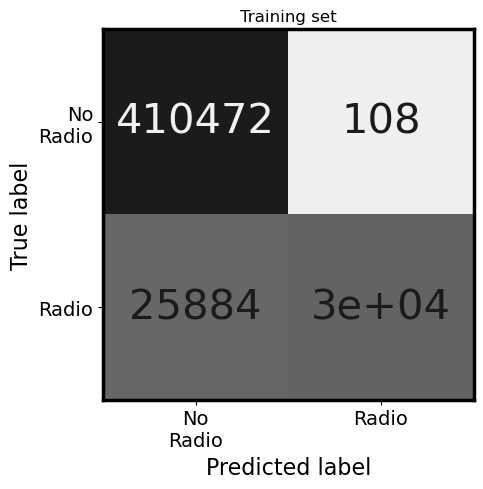

In [115]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_radio_detect_03.pdf', bbox_inches='tight')
plt.show()

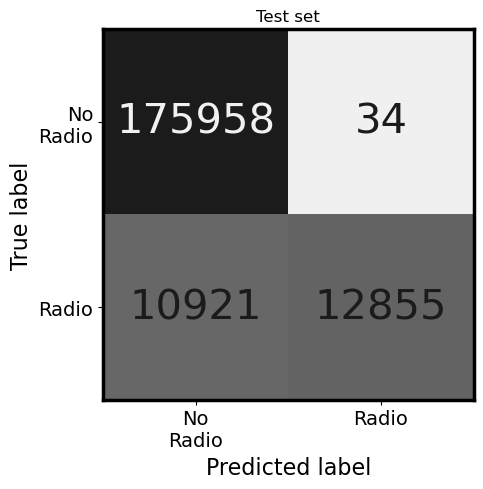

In [116]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_radio_detect_03.pdf', bbox_inches='tight')
plt.show()

In [117]:
# TN_radio_train, FP_radio_train, FN_radio_train, TP_radio_train = cm_mat_train.flatten().astype('float32')

In [118]:
MCC_radio_train    = MCC_from_CM(cm_mat_train)
ACC_radio_train    = ACC_from_CM(cm_mat_train)
F1_radio_train     = F1_from_CM(cm_mat_train)
Recall_radio_train = Recall_from_CM(cm_mat_train)

In [119]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_train:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_train:.4f}')
print(f'F1-score is                          F1 = {F1_radio_train:.4f}')
print(f'Recall is                           TPR = {Recall_radio_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.7072
Accuracy is                         ACC = 0.9442
F1-score is                          F1 = 0.6953
Recall is                           TPR = 0.5340


In [120]:
# TN_radio_test, FP_radio_test, FN_radio_test, TP_radio_test = cm_mat_test.flatten().astype('float32')

In [121]:
MCC_radio_test    = MCC_from_CM(cm_mat_test)
ACC_radio_test    = ACC_from_CM(cm_mat_test)
F1_radio_test     = F1_from_CM(cm_mat_test)
Recall_radio_test = Recall_from_CM(cm_mat_test)

In [122]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_test:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_test:.4f}')
print(f'F1-score is                          F1 = {F1_radio_test:.4f}')
print(f'Recall is                           TPR = {Recall_radio_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.7124
Accuracy is                         ACC = 0.9452
F1-score is                          F1 = 0.7012
Recall is                           TPR = 0.5407


Calculate ROC AUC values and plots.

In [123]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

In [124]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.98290
Area under the curve (ROC) for test       = 0.98336
Area under the curve (ROC) for validation = 0.86635


In [125]:
fpr_train, tpr_train, thresh_train = roc_curve(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,  tpr_test,  thresh_test  = roc_curve(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_val,   tpr_val,   thresh_val   = roc_curve(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

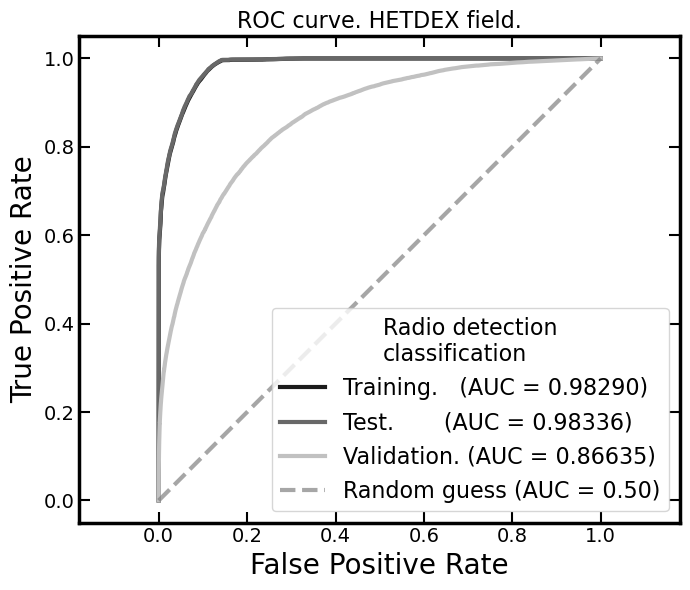

In [126]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
viz_test  = RocCurveDisplay(fpr=fpr_test,  tpr=tpr_test,  roc_auc=roc_auc_test)
viz_val   = RocCurveDisplay(fpr=fpr_val,   tpr=tpr_val,   roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1, lw=3, c=cm.get_cmap('cet_dimgray')(0.0), label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_val.plot(ax=ax1,   lw=3, c=cm.get_cmap('cet_dimgray')(0.8), label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='Radio detection\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_radio_detect_03.pdf', bbox_inches='tight')
plt.show()